In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.externals import joblib

import itertools

In [3]:
tf.logging.set_verbosity(tf.logging.INFO)
sess = tf.InteractiveSession()

In [4]:
scaler_y = joblib.load('../models/scaler_y.sav')

## Regressor with both continuous and categorical

In [5]:
train = pd.read_csv('../data/processed/train_all.csv')
train_numerical = pd.read_csv('../data/processed/train_numerical.csv')
train_categoric = pd.read_csv('../data/processed/train_categorical.csv')

In [6]:
df_test = pd.read_csv('../data/test.csv')
ID = df_test.Id

test = pd.read_csv('../data/processed/test_all.csv')

In [7]:
col_train_num = list(train_numerical.columns)
col_train_num_bis = list(train_numerical.columns)
col_train_cat = list(train_categoric.columns)
col_train_num_bis.remove('SalePrice')

In [8]:
COLUMNS = col_train_num
FEATURES = col_train_num_bis
LABEL = "SalePrice"
FEATURES_CAT = col_train_cat

In [9]:
# Train and Test 
training_set, validation_set = train_test_split(train, test_size=0.33, random_state=42)
training_set.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,TotalBsmtSF,LowQualFinSF,...,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,SaleType,SaleCondition
1013,0.235294,0.000000,0.036598,0.333333,0.857143,0.681159,0.833333,0.1575,0.249532,0.0,...,0.5,1.0,0.6,0.166667,1.0,1.0,1.0,1.0,1.000000,0.8
333,0.000000,0.191693,0.033186,0.000000,0.285714,0.565217,0.000000,0.0000,0.224891,0.0,...,1.0,1.0,0.6,0.666667,1.0,1.0,1.0,0.0,1.000000,0.8
433,0.588235,0.169329,0.012255,0.500000,0.428571,0.971014,0.950000,0.0450,0.392389,0.0,...,0.5,1.0,0.4,0.166667,0.0,1.0,1.0,1.0,0.666667,1.0
677,0.058824,0.159744,0.021968,0.166667,0.714286,0.355072,0.000000,0.0000,0.192140,0.0,...,1.0,1.0,0.6,0.833333,1.0,1.0,1.0,1.0,1.000000,0.8
1074,0.000000,0.364217,0.042333,0.500000,0.428571,0.855072,0.683333,0.0000,0.283843,0.0,...,0.5,1.0,1.0,0.166667,0.0,1.0,1.0,1.0,1.000000,0.8


In [10]:
training_set.shape

(949, 67)

In [11]:
validation_set.shape

(468, 67)

In [12]:
engineered_features = []

for continuous_feature in FEATURES:
    engineered_features.append(tf.contrib.layers.real_valued_column(continuous_feature))

for categorical_feature in FEATURES_CAT:
    sparse_column = tf.contrib.layers.sparse_column_with_hash_bucket(categorical_feature, hash_bucket_size=1000)
    engineered_features.append(tf.contrib.layers.embedding_column(sparse_id_column=sparse_column, dimension=16,combiner="sum"))

In [13]:
training_set[FEATURES_CAT] = training_set[FEATURES_CAT].applymap(str)
validation_set[FEATURES_CAT] = validation_set[FEATURES_CAT].applymap(str)
test[FEATURES_CAT] = test[FEATURES_CAT].applymap(str)

In [14]:
def input_fn(data_set, training = True):
    continuous_cols = {k: tf.constant(data_set[k].values) for k in FEATURES}
    categorical_cols = {k: tf.SparseTensor(indices=[[i, 0] for i in range(data_set[k].size)], values = data_set[k].values, dense_shape = [data_set[k].size, 1]) for k in FEATURES_CAT}

    # Merges the two dictionaries into one.
    feature_cols = dict(list(continuous_cols.items()) + list(categorical_cols.items()))
    
    if training == True:
        # Converts the label column into a constant Tensor.
        label = tf.constant(data_set[LABEL].values)

        # Returns the feature columns and the label.
        return feature_cols, label
    else:
        return feature_cols

In [15]:
tf.logging.set_verbosity(tf.logging.ERROR)
regressor = tf.contrib.learn.DNNRegressor(feature_columns = engineered_features,
                                          activation_fn = tf.nn.relu, hidden_units=[100, 50, 25, 12, 6])

In [16]:
regressor.fit(input_fn = lambda: input_fn(training_set) , steps=500)

DNNRegressor(params={'head': <tensorflow.contrib.learn.python.learn.estimators.head._RegressionHead object at 0x1c38f42d30>, 'hidden_units': [100, 50, 25, 12, 6], 'feature_columns': (_RealValuedColumn(column_name='MSSubClass', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='LotFrontage', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='LotArea', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='OverallQual', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='OverallCond', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='YearBuilt', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='YearRemodAdd', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_

In [17]:
ev = regressor.evaluate(input_fn=lambda: input_fn(validation_set, training = True), steps=1)
loss_score = ev["loss"]
print("Loss of validation set: {0:f}".format(loss_score))

Loss of validation set: 0.002043


In [18]:
y = regressor.predict(input_fn=lambda: input_fn(validation_set))
predictions = list(itertools.islice(y, validation_set.shape[0]))
predictions = pd.DataFrame(scaler_y.inverse_transform(np.array(predictions).reshape(validation_set.shape[0],1)))

In [19]:
reality = pd.DataFrame(scaler_y.inverse_transform(np.array(validation_set.SalePrice).reshape(validation_set.shape[0],1)))

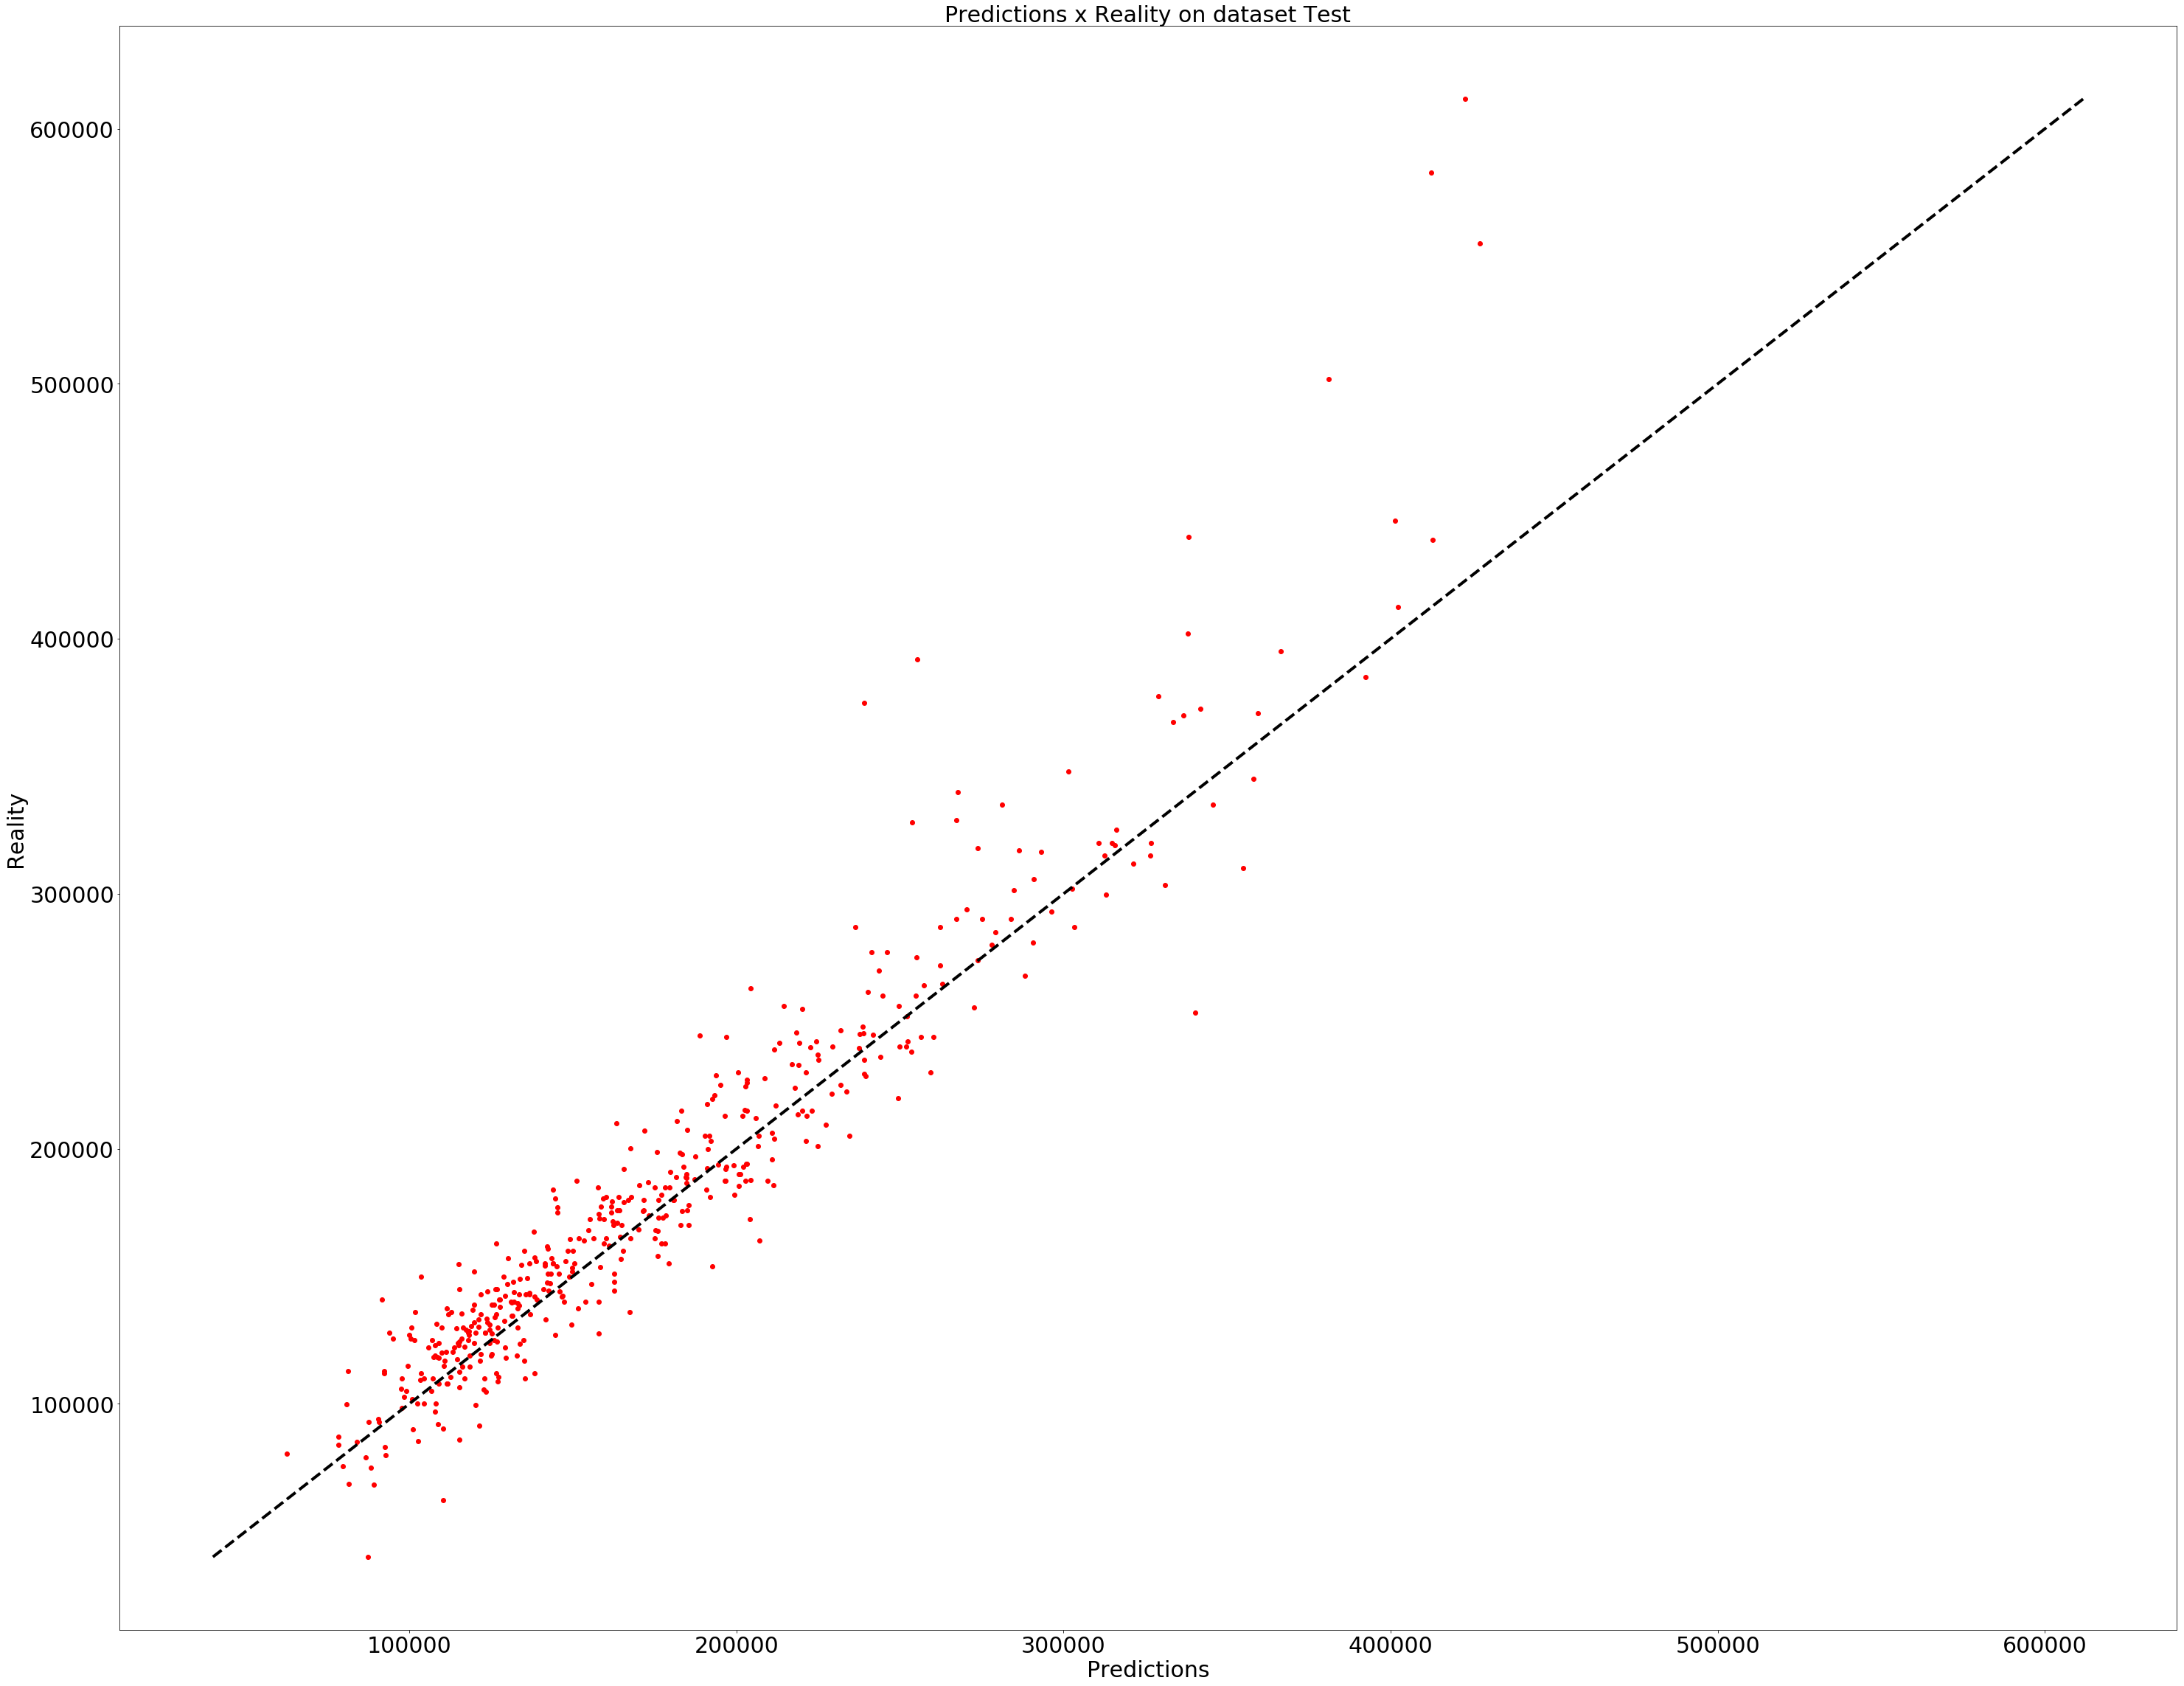

In [20]:
matplotlib.rc('xtick', labelsize=30) 
matplotlib.rc('ytick', labelsize=30) 

fig, ax = plt.subplots(figsize=(50, 40))

plt.style.use('ggplot')
plt.plot(predictions.values, reality.values, 'ro')
plt.xlabel('Predictions', fontsize = 30)
plt.ylabel('Reality', fontsize = 30)
plt.title('Predictions x Reality on dataset Test', fontsize = 30)
ax.plot([reality.min(), reality.max()], [reality.min(), reality.max()], 'k--', lw=4)
plt.show()

Submitting to kaggle.

In [21]:
y_predict = regressor.predict(input_fn=lambda: input_fn(test, training = False))

In [22]:
y_predict = list(itertools.islice(y_predict, test.shape[0]))
y_predict = pd.DataFrame(scaler_y.inverse_transform(np.array(y_predict).reshape(len(y_predict),1)), columns = [LABEL])
y_predict = y_predict.join(ID)
y_predict.to_csv("kaggle/submission_continuous_category.csv",index=False)

## Medium sized network

In [23]:
regressor_med = tf.contrib.learn.DNNRegressor(feature_columns = engineered_features, 
                                          activation_fn = tf.nn.relu, hidden_units=[50, 25, 12, 6, 3])

In [24]:
regressor_med.fit(input_fn = lambda: input_fn(training_set) , steps=500)

DNNRegressor(params={'head': <tensorflow.contrib.learn.python.learn.estimators.head._RegressionHead object at 0x1c62a05748>, 'hidden_units': [50, 25, 12, 6, 3], 'feature_columns': (_RealValuedColumn(column_name='MSSubClass', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='LotFrontage', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='LotArea', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='OverallQual', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='OverallCond', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='YearBuilt', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='YearRemodAdd', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_na

In [25]:
ev_med = regressor_med.evaluate(input_fn=lambda: input_fn(validation_set, training = True), steps=1)
loss_score2 = ev_med["loss"]
print("Loss of validation set: {0:f}".format(loss_score2))

Loss of validation set: 0.002740


In [26]:
y_predict = regressor_med.predict(input_fn=lambda: input_fn(test, training = False))

In [27]:
y_predict = list(itertools.islice(y_predict, test.shape[0]))
y_predict = pd.DataFrame(scaler_y.inverse_transform(np.array(y_predict).reshape(len(y_predict),1)), columns = [LABEL])
y_predict = y_predict.join(ID)
y_predict.to_csv("kaggle/submission_shallow.csv",index=False)

## Training a small sized network

20, 10, 5

In [28]:
regressor_small = tf.contrib.learn.DNNRegressor(feature_columns = engineered_features, 
                                          activation_fn = tf.nn.relu, hidden_units=[20, 10, 5])

In [29]:
regressor_small.fit(input_fn = lambda: input_fn(training_set) , steps=2000)

DNNRegressor(params={'head': <tensorflow.contrib.learn.python.learn.estimators.head._RegressionHead object at 0x1c6b57b438>, 'hidden_units': [20, 10, 5], 'feature_columns': (_RealValuedColumn(column_name='MSSubClass', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='LotFrontage', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='LotArea', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='OverallQual', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='OverallCond', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='YearBuilt', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='YearRemodAdd', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='Mas

In [30]:
ev_small = regressor_small.evaluate(input_fn=lambda: input_fn(validation_set, training = True), steps=1)
loss_score_small = ev_small["loss"]
print("Loss of validation set: {0:f}".format(loss_score_small))

Loss of validation set: 0.001631


## Shallow neural network with lesser number of neurons

In [31]:
for h in [5, 12, 25, 50, 100, 200, 400]:
    regressor_loop = tf.contrib.learn.DNNRegressor(feature_columns = engineered_features, 
                                          activation_fn = tf.nn.relu, hidden_units=[h])
    regressor_loop.fit(input_fn = lambda: input_fn(training_set) , steps=500)
    ev_loop = regressor_loop.evaluate(input_fn=lambda: input_fn(validation_set, training = True), steps=1)
    loss_score_loop = ev_loop["loss"]
    print("Neurons:",h,", Loss of validation set: {0:f}".format(loss_score_loop))

Neurons: 5 , Loss of validation set: 0.002095
Neurons: 12 , Loss of validation set: 0.001876
Neurons: 25 , Loss of validation set: 0.001925
Neurons: 50 , Loss of validation set: 0.001951
Neurons: 100 , Loss of validation set: 0.001944
Neurons: 200 , Loss of validation set: 0.001933
Neurons: 400 , Loss of validation set: 0.001968
